In [1]:
import warnings
warnings.filterwarnings('ignore')

# ch3 분류

## 3.1 MNIST

- 고등학생과 미국 인구조사국 직원들이 손으로 쓴 70000개의 작은 숫자 이미지를 모은 MNIST 데이터셋
- 머신러닝계의 hellow world

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

mnist는 dic 구조로 그 안에 있는 data와 target을 사용

In [3]:
x, y = mnist.data, mnist.target

print(x.shape)
y.shape

(70000, 784)


(70000,)

**data**
- 70000개의 데이터와 784(28x28픽셀)개의 특성이 있음
- 0(흰색) ~ 255(검정색) 강도를 나타냄

하나를 살펴보자.

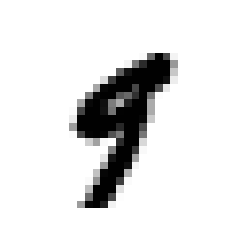

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = x[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis('off')
plt.show()

In [5]:
y[36000]

'9'

target이 5라는 것을 알려줌

학습 전에 테스트 데이터셋을 나눠줌(10000개 설정)

In [6]:
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

어떤 학습 알고리즘은 순서에 민감해서 셔플로 섞어준다.

In [7]:
import numpy as np

shuffle_index = np.random.permutation(60000)
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]
y_train = y_train.astype(np.int8) # y_train을 int 형식으로 바꿔야 에러가 안남

## 3.2 이진 분류기 훈련

숫자 9만 분류하는 이진 분류기를 먼저 해보겠다

In [8]:
y_train_9 = (y_train == 9) #9만 참, 나머지 거짓
y_test_9 = (y_test == 9)

사이킷런의 SGDClassifier 클래스를 사용해 **확률적 경사 하강법(SGD)**을 사용

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=10, random_state=42)
sgd_clf.fit(x_train, y_train_9)
sgd_clf.predict([some_digit])

array([False])

- 위에서 나온 9가 9인지에 대해 모델이 참이라고 함
- max_iter의 조절에 따라 결과가 달라짐

## 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정

사이킷런의 cross_val_score를 이용하여 교차 검증하기

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train_9, cv=4, scoring = "accuracy")

array([0.94320379, 0.9466    , 0.94433333, 0.95226348])

- sgd_clf 모델에서 x_train와 y_train_9 데이터를 4겹 학습시켜 정확도를 측정
- 모두 정확도가 91% 이상임

이번엔 클래스를 이용하여 '모두 9가 아님'인 분류기를 만들어보자

In [11]:
from sklearn.base import BaseEstimator

class Never9Classifier(BaseEstimator):
    def fit(self, x, y=None):
        pass
    def predict(self, x):
        return np.zeros((len(x),1), dtype = bool)

In [12]:
never_9_clf = Never9Classifier()
cross_val_score(never_9_clf, x_train, y_train_9, cv=4, scoring = "accuracy")

array([0.9002    , 0.90293333, 0.90113333, 0.89913333])

- 정확도가 약 90% 정도 된다.
- 이미지의 10% 정도가 9이기 때문인듯

In [13]:
a = len(y_train)
b = (y_train == 9).sum()

print("전체 {}개 중 {}개가 9인데 그 비율이 {}임".format(a,b,round(b/a*100,2)))

전체 60000개 중 5949개가 9인데 그 비율이 9.92임


### 3.2.2 오차 행렬

- 분류기 성능 평가하는 방법으로 오차행렬을 사용
- 잘못 분류된 횟수를 카운트하는 것이 기본 아이디어
- 비교하기 위해 예측값을 만들어야 함(test셋은 쓰면 안됨)

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_9, cv = 3)

예측값 생성. 이제 오차행렬 만들어보자.

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_9,y_train_pred)

array([[52744,  1307],
       [ 1825,  4124]], dtype=int64)

- confusion_matrix를 사용하여 오차행렬을 만듬
- 첫 행이 9가 아니라고 판정한 것인데, 53225개는 제대로 판정, 826개는 잘못 판정
- 두번째 행은 9라고 판정한 것인데, 2445개를 잘못 판정, 3504는 제대로 판정

![image](https://unsolvedproblem.github.io/assets/images/Hands-on/ch3fig3.png)

### 3.3.3 정밀도와 재현율

- 정밀도(Precision): 참이라고 예측했을 때, 진짜 참인 정도
- 재현율(Recall): 진짜 참인 것 중에, 예측이 참이라고 판단한 확률

![image](https://t1.daumcdn.net/cfile/tistory/993720485BE9521B20)
![image](https://t1.daumcdn.net/cfile/tistory/99692D3D5BE9521B0C)

사이킷런에서 함수를 제공해줌

In [16]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_9, y_train_pred), recall_score(y_train_9, y_train_pred)

(0.7593445037746271, 0.6932257522272651)

- 9로 판별된 이미지 중 72%만 참임
- 9 이미지 중 75%만 참으로 분류됨

### 3.3.4 정밀도/재현율 트레이드오프

- 정밀도가 높으면 재현율이 낮고 그 반대도 됨
- 트레이드오프를 잘 해야함
- 적절한 임계값으로 조절 해줌

임계값을 정할 수 있는 함수가 있음 <br>
먼저 cross_val_predict함수로 훈련 세트에 있는 모든 샘플의 점수를 구해야 함

In [17]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_9, cv=3, method = "decision_function")

In [19]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_9, y_scores)

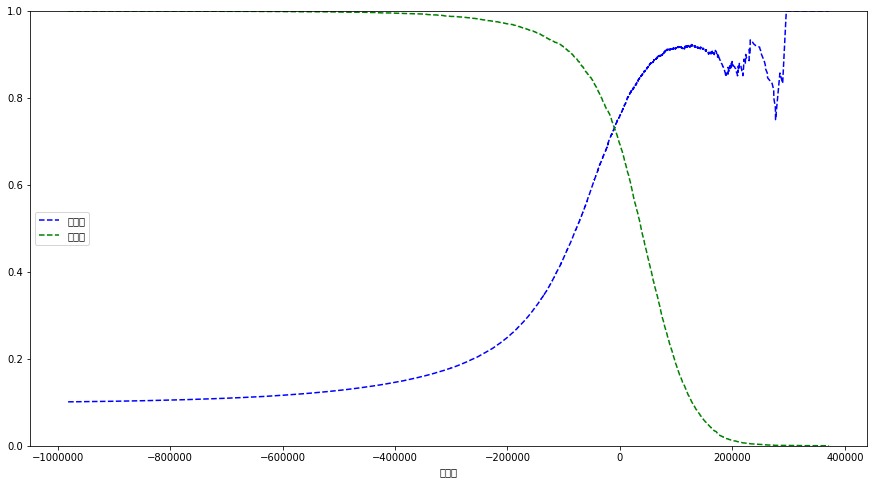

In [24]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g--", label="재현율")
    plt.xlabel("임계값")
    plt.legend(loc="center left")
    plt.ylim([0,1])

    
# plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams["figure.figsize"] = (15,8)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

- x축은 임계값이고 파란색이 정밀도, 초록색이 재현율
- 누군가 99% 정밀도를 달성하자라고 말하면 반드시 재현율은 얼마에서 라고 물어봐야 됨

### 3.3.5 ROC 곡선

- 이진 분류에서 널리 사용하는 도구
- 거짓 양성 비율에 대한 진짜 양성 비율의 곡선

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_9, y_scores)

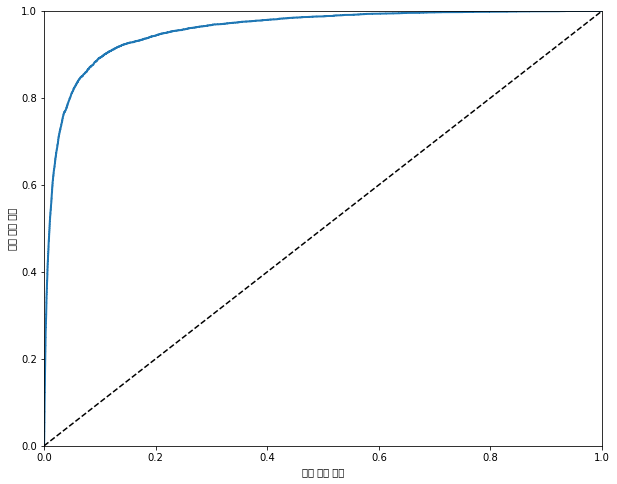

In [34]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('거짓 양성 비율')
    plt.ylabel('진짜 양성 비율')
    
plt.rcParams["figure.figsize"] = (10,8)
plot_roc_curve(fpr, tpr)
plt.show()

## 3.4 다중 분류

- 둘 이상의 클래스를 구별
- 랜덤 포레스트 분류기 등 일부 알고리즘은 여러 개의 클래스를 직접 처리할 수 있음
- SVM 등 이진 분류만 가능할 경우, 여러개의 이진 분류기를 만들어 다중 분류로 사용
- OvA(일대다): 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택
- OvO(일대일): 각 조합마다 이진 분류기를 훈련

In [35]:
sgd_clf.fit(x_train, y_train)
sgd_clf.predict([some_digit])

array([4], dtype=int8)

In [36]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-432070.92017819, -303678.74376745, -385825.26954765,
         -67553.89303775,   61472.72025847,  -86647.53546252,
        -405280.60594003,  -82467.59193373, -166406.20281724,
        -130421.70620069]])

In [37]:
np.argmax(some_digit_scores)

4

In [38]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [40]:
sgd_clf.classes_[4]

4

In [41]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(x_train, y_train)
ovo_clf.predict([some_digit])

array([9], dtype=int8)

In [43]:
len(ovo_clf.estimators_)

45